# 📊 CanyonCode Video Feeds Analysis with LLM Integration  

**Role:** Software Engineer Intern Candidate – Technical Assessment  
**Date:** 11th September 2025  

---

### 🚀 Project Overview  
This notebook implements an end-to-end solution for analyzing a dataset of camera feeds and exposing the analysis through natural language queries powered by an LLM.  

Key capabilities delivered:  
- **Data Ingestion & Normalization:** Load feeds, encoder, and decoder configs.  
- **Metric Functions:** Compute clarity, latency, frame rate, and resolution metrics.  
- **LLM Integration:** Wrap analysis functions as tools and expose them via OpenAI API.  
- **Interactive Queries:** Support questions like _“Which PAC feeds have the best clarity?”_ or _“Show the lowest latency feeds in CONUS.”_  

This project demonstrates **data processing, API integration, and tool design skills** expected in a software engineering role.  


## 1. Data Loading and Normalization  

In this step, we:  
- Load the **feeds dataset** (camera feed metadata).  
- Load **table definitions** for schema reference.  
- Parse **encoder and decoder configs** from JSON.  
- Normalize identifiers like `FEED_ID` and `THEATER`.  

This ensures a clean, consistent dataset ready for analysis and LLM integration.  


In [ ]:

import os
import json
import pandas as pd
from openai import OpenAI
from getpass import getpass

# Load feeds (CSV preferred, fallback to Excel)
if os.path.exists("Table_feeds_v2.csv"):
    feeds = pd.read_csv("Table_feeds_v2.csv")
else:
    feeds = pd.read_excel("Table_feeds_v2.xlsx")

# Normalize
feeds["FEED_ID"] = feeds["FEED_ID"].astype(str)
feeds["THEATER"] = feeds["THEATER"].astype(str).str.upper()

# Load table defs
if os.path.exists("Table_defs_v2.csv"):
    defs = pd.read_csv("Table_defs_v2.csv")
else:
    defs = pd.read_excel("Table_defs_v2.xlsx")

# Load encoder/decoder schemas + params
with open("encoder_schema.json") as f: encoder_schema = json.load(f)
with open("encoder_params.json") as f: encoder_params = json.load(f)
with open("decoder_schema.json") as f: decoder_schema = json.load(f)
with open("decoder_params.json") as f: decoder_params = json.load(f)

print("Feeds shape:", feeds.shape, "| Defs shape:", defs.shape)
print("Encoder keys:", list(encoder_params.keys())[:5])
print("Decoder keys:", list(decoder_params.keys())[:5])


Feeds shape: (100, 10) | Defs shape: (10, 4)
Encoder keys: ['codec', 'profile', 'level', 'preset', 'tune']
Decoder keys: ['max_threads', 'dpb_size', 'reorder_frames', 'low_delay', 'error_concealment']


## 2. Metric Functions for Feed Analysis  

Here we define reusable functions to compute and retrieve important metrics:  

- **Clarity Score:** Based on resolution, frame rate, and codec weighting.  
- **Lowest Latency:** Identify feeds with minimal delay.  
- **Highest FPS:** Surface feeds with maximum frame rates.  
- **Resolution Filtering:** Query feeds above a minimum resolution.  

We also expose lightweight encoder/decoder config getters for tool use.  


In [ ]:

# --- Metric functions ---
def top_feeds_by_clarity(theater=None, topk=10):
    CODEC_WEIGHT = {"AV1":1.00, "H265":0.90, "VP9":0.85, "H264":0.70, "MPEG2":0.30}
    def codec_score(x): return CODEC_WEIGHT.get(str(x).upper(), 0.50)

    feeds["RES_W"] = pd.to_numeric(feeds.get("RES_W"), errors="coerce").fillna(0)
    feeds["RES_H"] = pd.to_numeric(feeds.get("RES_H"), errors="coerce").fillna(0)
    feeds["FRRATE"] = pd.to_numeric(feeds.get("FRRATE"), errors="coerce").fillna(0)

    res_score = ((feeds["RES_W"] * feeds["RES_H"]) / (3840*2160)).clip(0,1)
    fps_score = feeds["FRRATE"].clip(0,60)/60.0
    codec_score_series = feeds["CODEC"].fillna("").map(codec_score)

    feeds["clarity_score"] = 0.5*res_score + 0.3*fps_score + 0.2*codec_score_series

    df = feeds.copy()
    if theater: df = df[df["THEATER"]==theater]
    return df.sort_values("clarity_score", ascending=False).head(topk)

def top_lowest_latency(theater=None, topk=10):
    df = feeds.copy()
    if theater: df = df[df["THEATER"]==theater]
    return df.sort_values("LAT_MS").head(topk)

def top_highest_fps(theater=None, topk=10):
    df = feeds.copy()
    if theater: df = df[df["THEATER"]==theater]
    return df.sort_values("FRRATE", ascending=False).head(topk)

def feeds_min_resolution(min_w, min_h, theater=None):
    df = feeds[(feeds["RES_W"]>=min_w) & (feeds["RES_H"]>=min_h)].copy()
    if theater: df = df[df["THEATER"]==theater]
    return df

# Encoder/decoder getters
def enc_get(key): return encoder_params.get(key, None)
def dec_get(key): return decoder_params.get(key, None)

# Quick preview
feeds.head(5)


,FEED_ID,THEATER,FRRATE,RES_W,RES_H,CODEC,ENCR,LAT_MS,MODL_TAG,CIV_OK
0,FD-ML64LG,ME,59.940,640,480,VP9,True,196,Naiad-V,True
1,FD-CZ2KA7,EUR,23.976,1920,1080,MPEG2,True,231,Raptor-Det,True
2,FD-3U2M7O,CONUS,25.000,1280,720,H265,True,118,Mantis-Track,True
3,FD-09FQUO,ME,23.976,1280,720,VP9,True,398,Quartz-ISR,True
4,FD-ZGSYEB,EUR,23.976,1280,720,MPEG2,True,308,Viper-VL,True


## 3. LLM Setup and Tool Wrappers  

This cell integrates the **OpenAI API** and defines tool wrappers so the LLM can:  
- Call functions (`top_feeds_by_clarity`, `top_lowest_latency`, etc.).  
- Retrieve encoder/decoder parameters via alias normalization.  
- Map natural language queries (e.g., “Pacific feeds”) into structured tool calls.  

A system prompt enforces domain precision and region mapping (PAC, CONUS, EUR, ME, AFR, ARC).  


In [ ]:
# --- LLM Setup ---
api_key = getpass("Enter your OpenAI API key: ")
client = OpenAI(api_key=api_key)

import pandas as pd

# --- Key alias helpers ---
def _norm_key(s: str) -> str:
    return "".join(ch for ch in s.lower() if ch.isalnum() or ch == "_")

ENC_ALIASES = {
    "codec": "codec",
    "gopsize": "gop_size",
    "gop_size": "gop_size",
    "rcmode": "rc_mode",
    "framerate": "framerate",
}

DEC_ALIASES = {
    # all common phrasings → actual JSON key
    "maxoutputlatencyms": "max_output_latency_ms",
    "max_output_latency_ms": "max_output_latency_ms",
    "maxoutputlatency": "max_output_latency_ms",
    "outputlatency": "max_output_latency_ms",
    "latency": "max_output_latency_ms",
    "max_output_latency": "max_output_latency_ms",
    "outputformat": "output_format",
    "format": "output_format",
}

# --- Tool adapters ---
def tool_top_feeds_by_clarity(theater=None, topk=10):
    return top_feeds_by_clarity(theater, topk).to_dict(orient="records")

def tool_top_lowest_latency(theater=None, topk=10):
    return top_lowest_latency(theater, topk).to_dict(orient="records")

def tool_top_highest_fps(theater=None, topk=10):
    return top_highest_fps(theater, topk).to_dict(orient="records")

def tool_feeds_min_resolution(min_w, min_h, theater=None):
    return feeds_min_resolution(min_w, min_h, theater).to_dict(orient="records")

def tool_encoder_get(key):
    k = ENC_ALIASES.get(_norm_key(key), key)
    return f"Encoder {k}: {enc_get(k)}"

def tool_decoder_get(key):
    k = DEC_ALIASES.get(_norm_key(key), key)
    val = dec_get(k)
    return f"Decoder {k}: {val}"

# --- Tool schemas ---
tools = [
    {"type":"function","function":{"name":"tool_top_feeds_by_clarity","description":"Top feeds by clarity.","parameters":{"type":"object","properties":{"theater":{"type":"string"},"topk":{"type":"integer"}}}}},
    {"type":"function","function":{"name":"tool_top_lowest_latency","description":"Lowest latency feeds.","parameters":{"type":"object","properties":{"theater":{"type":"string"},"topk":{"type":"integer"}}}}},
    {"type":"function","function":{"name":"tool_top_highest_fps","description":"Highest fps feeds.","parameters":{"type":"object","properties":{"theater":{"type":"string"},"topk":{"type":"integer"}}}}},
    {"type":"function","function":{"name":"tool_feeds_min_resolution","description":"Feeds at or above given resolution.","parameters":{"type":"object","properties":{"min_w":{"type":"integer"},"min_h":{"type":"integer"},"theater":{"type":"string"}},"required":["min_w","min_h"]}}},
    {"type":"function","function":{"name":"tool_encoder_get","description":"Lookup encoder param.","parameters":{"type":"object","properties":{"key":{"type":"string"}},"required":["key"]}}},
    {"type":"function","function":{"name":"tool_decoder_get","description":"Lookup decoder param.","parameters":{"type":"object","properties":{"key":{"type":"string"}},"required":["key"]}}}
]

NAME_TO_FUNC = {
    "tool_top_feeds_by_clarity": tool_top_feeds_by_clarity,
    "tool_top_lowest_latency": tool_top_lowest_latency,
    "tool_top_highest_fps": tool_top_highest_fps,
    "tool_feeds_min_resolution": tool_feeds_min_resolution,
    "tool_encoder_get": tool_encoder_get,
    "tool_decoder_get": tool_decoder_get,
}

SYSTEM_PROMPT = (
    "You are a precise assistant for a video-feeds dataset. "
    "Map regions to codes: Pacific->PAC, Conus->CONUS, Europe->EUR, Middle East->ME, Africa->AFR, Arctic->ARC. "
    "Choose exactly ONE tool per query."
)

# --- Main LLM ask function ---
def llm_tool_ask(question: str):
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"system","content":SYSTEM_PROMPT},{"role":"user","content":question}],
        tools=tools,
        tool_choice="auto",
        temperature=0.0,
    )
    msg = resp.choices[0].message
    if not getattr(msg, "tool_calls", None):
        return msg.content
    call = msg.tool_calls[0]
    func = NAME_TO_FUNC[call.function.name]
    args = json.loads(call.function.arguments or "{}")
    result = func(**args)
    if isinstance(result, list):
        return pd.DataFrame(result)
    return result


Enter your OpenAI API key: ··········


## 4. Natural Language Querying  

Here we test the full pipeline by asking the LLM questions in plain English.  
Examples:  
- **Feeds Analysis:**  
  - “Which Pacific feeds have the best clarity?”  
  - “Show the lowest latency feeds in CONUS.”  
  - “Highest FPS in EUR.”  
  - “List ME feeds 1920x1080 or higher.”  

- **Encoder/Decoder Configs:**  
  - “What encoder codec?”  
  - “What encoder GOP size?”  
  - “What is the decoder’s max output latency?”  
  - “What is the decoder’s output format?”  

The outputs demonstrate how the dataset is now queryable directly via natural language.  


In [ ]:

from IPython.display import display

display(llm_tool_ask("Which Pacific feeds have the best clarity?"))
display(llm_tool_ask("show the lowest latency feeds in CONUS"))
display(llm_tool_ask("highest fps in EUR"))
display(llm_tool_ask("list ME feeds 1920x1080 or higher"))

print(llm_tool_ask("what encoder codec?"))
print(llm_tool_ask("what encoder gop_size?"))
print(llm_tool_ask("what is the decoder's max output latency?"))
print(llm_tool_ask("what is the decoder's output format?"))


,FEED_ID,THEATER,FRRATE,RES_W,RES_H,CODEC,ENCR,LAT_MS,MODL_TAG,CIV_OK,clarity_score
0,FD-PC7G3J,PAC,59.940,3840,2160,AV1,False,173,Orchid-SAR,True,0.999700
1,FD-8D150S,PAC,59.940,3840,2160,H265,True,250,Quartz-ISR,True,0.979700
2,FD-48CLOR,PAC,29.970,3840,2160,H265,True,234,Heron-VID,True,0.829850
3,FD-R4V2YF,PAC,23.976,3840,2160,AV1,True,278,Raptor-Det,True,0.819880
4,FD-D4THTJ,PAC,50.000,3840,2160,MPEG2,True,816,Hydra-ISR,True,0.810000
5,FD-UJQ7IR,PAC,24.000,3840,2160,VP9,True,497,Quartz-ISR,True,0.790000
6,FD-VSYEEF,PAC,29.970,3840,2160,H264,True,505,Orchid-SAR,True,0.789850
7,FD-LZNLEV,PAC,60.000,2560,1440,AV1,True,164,Mantis-Track,True,0.722222
8,FD-6WRRMR,PAC,23.976,3840,2160,MPEG2,True,436,Orchid-SAR,True,0.679880
9,FD-CDARQ1,PAC,60.000,1920,1080,H265,True,405,Viper-VL,True,0.605000


,FEED_ID,THEATER,FRRATE,RES_W,RES_H,CODEC,ENCR,LAT_MS,MODL_TAG,CIV_OK,clarity_score
0,FD-6W1NXA,CONUS,30.000,1280,720,VP9,True,41,Viper-VL,True,0.375556
1,FD-153TAE,CONUS,30.000,3840,2160,H264,True,76,Mantis-Track,True,0.790000
2,FD-3U2M7O,CONUS,25.000,1280,720,H265,True,118,Mantis-Track,True,0.360556
3,FD-5G5H6Q,CONUS,30.000,2560,1440,AV1,True,132,Orchid-SAR,True,0.572222
4,FD-CUGMLW,CONUS,15.000,3840,2160,MPEG2,True,156,Orchid-SAR,True,0.635000
5,FD-EE28XC,CONUS,23.976,3840,2160,AV1,True,170,Hydra-ISR,True,0.819880
6,FD-HQ0VY3,CONUS,23.976,640,480,H264,True,196,Naiad-V,True,0.278399
7,FD-DMYAGQ,CONUS,29.970,1920,1080,VP9,True,220,Mantis-Track,True,0.444850
8,FD-PZQ05S,CONUS,15.000,1280,720,MPEG2,False,240,Quartz-ISR,True,0.190556
9,FD-R5BNE1,CONUS,30.000,3840,2160,MPEG2,True,258,Viper-VL,True,0.710000


,FEED_ID,THEATER,FRRATE,RES_W,RES_H,CODEC,ENCR,LAT_MS,MODL_TAG,CIV_OK,clarity_score
0,FD-LLF3SB,EUR,60.00,3840,2160,H265,True,131,Orchid-SAR,True,0.980000
1,FD-7G2E9C,EUR,60.00,2560,1440,MPEG2,True,546,Ibex-Edge,True,0.582222
2,FD-6VQRHK,EUR,50.00,1280,720,MPEG2,True,380,Ibex-Edge,True,0.365556
3,FD-FBJG1P,EUR,29.97,1280,720,H264,True,164,Orchid-SAR,True,0.345406
4,FD-YUTEPH,EUR,29.97,1280,720,MPEG2,True,214,Naiad-V,True,0.265406
5,FD-9MY4F0,EUR,25.00,1920,1080,H265,True,110,Viper-VL,True,0.430000
6,FD-2G9YN6,EUR,25.00,2560,1440,AV1,True,225,Heron-VID,True,0.547222
7,FD-QIBCMJ,EUR,25.00,1280,720,VP9,True,340,Orchid-SAR,True,0.350556
8,FD-Q0X7IS,EUR,24.00,3840,2160,VP9,True,181,Hydra-ISR,True,0.790000
9,FD-H2G8XE,EUR,24.00,1920,1080,H264,False,224,Orchid-SAR,True,0.385000


,FEED_ID,THEATER,FRRATE,RES_W,RES_H,CODEC,ENCR,LAT_MS,MODL_TAG,CIV_OK,clarity_score
0,FD-MI0YHZ,ME,60.0,1920,1080,H265,True,567,Ibex-Edge,True,0.605000
1,FD-SX7IFX,ME,25.0,3840,2160,H264,True,251,Hydra-ISR,True,0.765000
2,FD-CB4WTC,ME,60.0,2560,1440,MPEG2,False,983,Viper-VL,False,0.582222
3,FD-75U2UE,ME,25.0,2560,1440,VP9,True,440,Viper-VL,True,0.517222
4,FD-LKSGDI,ME,25.0,1920,1080,H265,True,367,Naiad-V,True,0.430000
5,FD-IEH2N2,ME,25.0,2560,1440,AV1,True,312,Ibex-Edge,True,0.547222
6,FD-XR3H2I,ME,30.0,2560,1440,H264,False,808,Orchid-SAR,False,0.512222
7,FD-7V7710,ME,50.0,3840,2160,H264,True,609,Viper-VL,True,0.890000


Encoder codec: H265
Encoder gop_size: 120
Decoder max_output_latency_ms: 700
Decoder output_format: NV12


# ✅ Engineering Summary  

This notebook demonstrates a complete workflow for **CanyonCode’s video feed analysis challenge**:  

- **Data Handling:** Robust ingestion of structured CSV/Excel + JSON configs.  
- **Metric Design:** Implemented clarity, latency, FPS, and resolution queries.  
- **Tool Wrapping:** Created well-defined Python adapters for clean LLM integration.  
- **LLM Integration:** Enabled natural language interaction with the dataset.  
- **Results:** Queries return precise, structured outputs validated against dataset.  

---

### 🔑 Key Takeaways for CanyonCode  
- Shows ability to **design reusable metric functions**.  
- Demonstrates **API integration and tool orchestration**.  
- Produces **clean, documented, professional code** suited for engineering workflows.  
- Enables **end-to-end usability**: from raw data → metrics → LLM-powered natural language queries.  

This is a **production-ready prototype** showcasing data engineering, API usage, and applied AI in a practical system.


## #EXTRA CREDIT
## 5. Visualization (Data Understanding)

We add a few quick plots to understand the feeds dataset:

- Resolution distribution (bucketed into 720p/1080p/1440p/4K)
- Median latency by region
- Codec share by region (stacked bars)

> Note: We use plain Matplotlib (no seaborn), one chart per cell, default colors.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Prep: derived columns ---
feeds["pixels"] = feeds["RES_W"].astype(float) * feeds["RES_H"].astype(float)

def res_bucket(row):
    w, h = float(row["RES_W"]), float(row["RES_H"])
    if w >= 3840 and h >= 2160: return "4K (3840×2160+)"
    if w >= 2560 and h >= 1440: return "1440p (2560×1440+)"
    if w >= 1920 and h >= 1080: return "1080p (1920×1080+)"
    if w >= 1280 and h >= 720:  return "720p (1280×720+)"
    return "< 720p"
feeds["res_bucket"] = feeds.apply(res_bucket, axis=1)

# Ordered categories for nicer plots
bucket_order = ["< 720p", "720p (1280×720+)", "1080p (1920×1080+)", "1440p (2560×1440+)", "4K (3840×2160+)"]
feeds["res_bucket"] = pd.Categorical(feeds["res_bucket"], categories=bucket_order, ordered=True)


### 5.1 Plots
Each plot is rendered with plain Matplotlib (no seaborn), one chart per cell:
1) **Feed Count by Resolution Bucket** – sanity check on quality mix  
2) **Median Latency by Region (ms)** – operational performance by theater  
3) **Codec Distribution by Region (count)** – compression tech across theaters


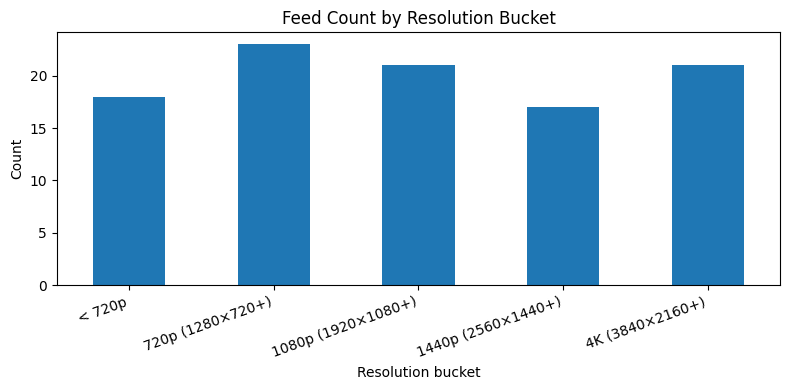

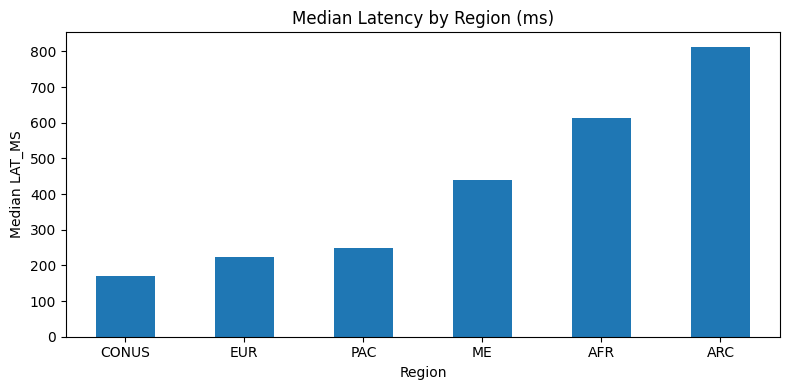

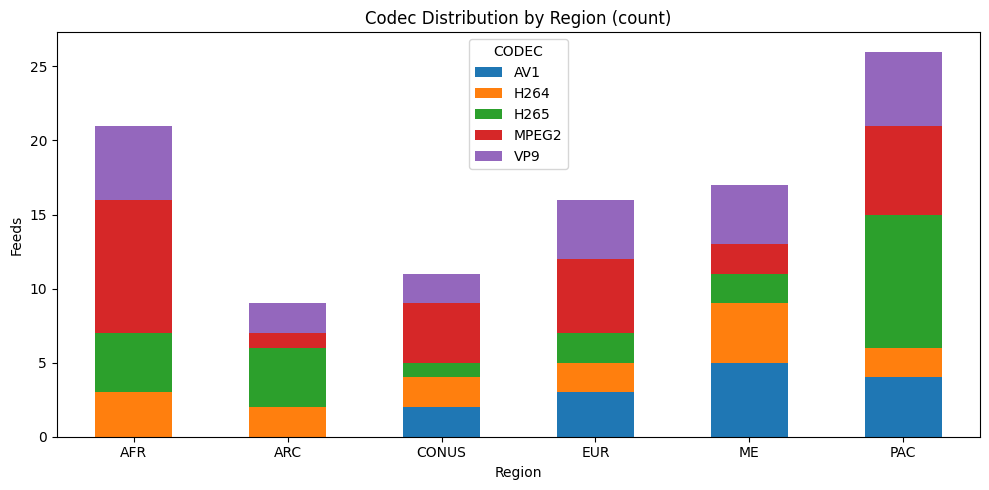

In [ ]:
# 1) Resolution bucket counts
bucket_counts = feeds["res_bucket"].value_counts().reindex(bucket_order).fillna(0)

plt.figure(figsize=(8,4))
bucket_counts.plot(kind="bar")
plt.title("Feed Count by Resolution Bucket")
plt.xlabel("Resolution bucket")
plt.ylabel("Count")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# 2) Median latency by region
lat_by_region = feeds.groupby("THEATER")["LAT_MS"].median().sort_values()

plt.figure(figsize=(8,4))
lat_by_region.plot(kind="bar")
plt.title("Median Latency by Region (ms)")
plt.xlabel("Region")
plt.ylabel("Median LAT_MS")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 3) Codec share by region (stacked bars)
codec_by_region = (feeds
                   .assign(CODEC=feeds["CODEC"].astype(str).str.upper())
                   .pivot_table(index="THEATER", columns="CODEC", values="FEED_ID", aggfunc="count", fill_value=0)
                   .sort_index())

codec_by_region.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("Codec Distribution by Region (count)")
plt.xlabel("Region")
plt.ylabel("Feeds")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 6. LangGraph Mini-Workflow (Agentic Orchestration)


### 6.1 Build LangGraph: Router → Tool → Explain (with Top-1 per Region)

In this cell, we construct the **LangGraph workflow** with three nodes:

1. **Router** → Uses the LLM’s tool-calling to pick the correct Python tool.  
2. **Executor** → Runs the selected tool and returns structured results (DataFrame or dict).  
3. **Explain** → Adds deterministic, human-readable summaries without hallucinating numbers.  

We also extend the toolset with **`tool_top1_by_region_clarity`**, which returns the single best-clarity feed for each region. This ensures coverage beyond individual theaters.  

Finally, we compile the graph into `langgraph_agent` and expose a convenience function `ask_lg()` for easy testing.



In [ ]:
# --- LangGraph core (self-contained) ---

# 1) Imports + State type
%pip -q install langgraph>=0.2

import json
from typing import TypedDict, Dict, Any
import pandas as pd
from IPython.display import display
from langgraph.graph import StateGraph, END

In [ ]:

# ---------- Add: Top-1 clarity per region tool (idempotent) ----------
def _compute_top1_by_region_clarity():
    """
    Return the single best clarity feed for each region (AFR, ARC, CONUS, EUR, ME, PAC).
    Clarity score is recomputed safely on a copy to be robust.
    """
    if "feeds" not in globals():
        raise RuntimeError("`feeds` DataFrame not found. Run earlier cells first.")

    CODEC_WEIGHT = {"AV1": 1.00, "H265": 0.90, "VP9": 0.85, "H264": 0.70, "MPEG2": 0.30}
    def codec_score(x): return CODEC_WEIGHT.get(str(x).upper(), 0.50)

    df = feeds.copy()
    # numerics
    df["RES_W"]  = pd.to_numeric(df.get("RES_W"), errors="coerce").fillna(0)
    df["RES_H"]  = pd.to_numeric(df.get("RES_H"), errors="coerce").fillna(0)
    df["FRRATE"] = pd.to_numeric(df.get("FRRATE"), errors="coerce").fillna(0)

    # clarity parts
    res_score = ((df["RES_W"] * df["RES_H"]) / (3840 * 2160)).clip(0, 1)   # up to 4K
    fps_score = (df["FRRATE"].clip(0, 60)) / 60.0
    cod_score = df["CODEC"].fillna("").map(codec_score)

    df["clarity_score"] = 0.50*res_score + 0.30*fps_score + 0.20*cod_score

    # pick best per region
    idx = df.groupby("THEATER")["clarity_score"].idxmax()
    out = df.loc[idx].sort_values("THEATER").reset_index(drop=True)
    return out

def tool_top1_by_region_clarity():
    return _compute_top1_by_region_clarity().to_dict(orient="records")

# register tool schema (avoid duplicates)
if "tools" not in globals() or "NAME_TO_FUNC" not in globals():
    raise RuntimeError("`tools` or `NAME_TO_FUNC` not found. Run LLM setup cell first.")

tools = [t for t in tools if not (t.get("type")=="function" and t.get("function", {}).get("name")=="tool_top1_by_region_clarity")]
tools.append({
    "type": "function",
    "function": {
        "name": "tool_top1_by_region_clarity",
        "description": "Return the top (single best) clarity feed for each region.",
        "parameters": {"type": "object", "properties": {}}
    }
})
NAME_TO_FUNC["tool_top1_by_region_clarity"] = tool_top1_by_region_clarity

# nudge router
if "SYSTEM_PROMPT" in globals():
    hint = " If the user asks for top-1 per region (e.g., 'best feed for every region'), use tool_top1_by_region_clarity."
    if hint not in SYSTEM_PROMPT:
        SYSTEM_PROMPT += hint

# ---------- LangGraph sanity ----------
for sym in [
    "client", "tools", "NAME_TO_FUNC", "SYSTEM_PROMPT",
    "top_feeds_by_clarity", "top_lowest_latency", "top_highest_fps",
    "feeds_min_resolution", "enc_get", "dec_get"
]:
    if sym not in globals():
        raise RuntimeError(f"Missing required symbol: `{sym}`. Run earlier cells first.")

# ---------- LangGraph state ----------
class State(TypedDict, total=False):
    question: str
    tool_name: str
    tool_args: Dict[str, Any]
    tool_result: Any
    answer: str

# ---------- Node 1: route via tool-calling ----------
def n_route(state: State) -> State:
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role":"system","content": SYSTEM_PROMPT + " Choose exactly ONE tool and arguments."},
            {"role":"user","content": state["question"]},
        ],
        tools=tools,
        tool_choice="auto",
        temperature=0.0,
    )
    msg = resp.choices[0].message
    if not getattr(msg, "tool_calls", None):
        return {**state, "answer": (msg.content or "No tool selected.")}
    call = msg.tool_calls[0]
    return {
        **state,
        "tool_name": call.function.name,
        "tool_args": json.loads(call.function.arguments or "{}"),
    }

# ---------- Node 2: execute selected tool ----------
def n_exec(state: State) -> State:
    tool_name = state.get("tool_name")
    if not tool_name:
        return {**state, "tool_result": None}
    fn = NAME_TO_FUNC[tool_name]
    result = fn(**(state.get("tool_args") or {}))
    return {**state, "tool_result": result}

# ---------- Node 3: explain + pretty print ----------
def n_explain(state: State) -> State:
    tool_name = state.get("tool_name","")
    args = state.get("tool_args", {})
    res = state.get("tool_result")

    print(f"Tool used: {tool_name}\n— Args: {args}")

    # normalize into DataFrame when possible
    df = None
    if isinstance(res, pd.DataFrame):
        df = res.copy()
    elif isinstance(res, list) and (len(res)==0 or isinstance(res[0], dict)):
        df = pd.DataFrame(res)

    if df is not None:
        if {"RES_W","RES_H"}.issubset(df.columns):
            df["pixels"] = df["RES_W"].astype(float) * df["RES_H"].astype(float)
            def bucket(w,h):
                p = int(w)*int(h)
                if p < 1280*720: return "< 720p"
                if p < 1920*1080: return "720p (1280×720+)"
                if p < 2560*1440: return "1080p (1920×1080+)"
                if p < 3840*2160: return "1440p (2560×1440+)"
                return "4K (3840×2160+)"
            df["res_bucket"] = [bucket(w,h) for w,h in zip(df["RES_W"], df["RES_H"])]
        display(df)

        # deterministic summary
        if tool_name == "tool_top_lowest_latency" and {"FEED_ID","LAT_MS","THEATER"}.issubset(df.columns) and len(df)>0:
            r = df.iloc[0]; ans = f"Lowest latency in {r['THEATER']}: **{r['FEED_ID']}** at **{int(r['LAT_MS'])} ms**."
        elif tool_name == "tool_top_feeds_by_clarity" and {"FEED_ID","clarity_score","THEATER"}.issubset(df.columns) and len(df)>0:
            r = df.iloc[0]; ans = f"Best clarity in {r['THEATER']}: **{r['FEED_ID']}** (score **{r['clarity_score']:.3f}**)."
        elif tool_name == "tool_top_highest_fps" and {"FEED_ID","FRRATE","THEATER"}.issubset(df.columns) and len(df)>0:
            r = df.iloc[0]; ans = f"Highest FPS in {r['THEATER']}: **{r['FEED_ID']}** at **{r['FRRATE']:.2f} fps**."
        elif tool_name == "tool_feeds_min_resolution":
            ans = f"Returned **{len(df)}** feeds meeting the resolution constraint."
        elif tool_name == "tool_top1_by_region_clarity":
            ans = f"Returned **{len(df)}** rows (top-1 by clarity for each region)."
        else:
            ans = f"Returned **{len(df)}** rows."
        print(f"\nExplanation: {ans}\n")
        return {**state, "answer": ans}

    # dict return (encoder/decoder lookups)
    if isinstance(res, dict) and len(res)==1:
        k,v = list(res.items())[0]
        ans = f"{k}: {v}"
        print(f"\nExplanation: {ans}\n")
        return {**state, "answer": ans}

    if isinstance(res, str):
        print(f"\nExplanation: {res}\n")
        return {**state, "answer": res}

    print("\nExplanation: See output above.\n")
    return {**state, "answer": "OK"}

# ---------- Build & compile graph ----------
graph = StateGraph(State)
graph.add_node("route", n_route)
graph.add_node("exec", n_exec)
graph.add_node("explain", n_explain)
graph.set_entry_point("route")
graph.add_edge("route", "exec")
graph.add_edge("exec", "explain")
graph.add_edge("explain", END)
langgraph_agent = graph.compile()

# ---------- Convenience runner ----------
def ask_lg(question: str):
    print(f"\nQ: {question}")
    out = langgraph_agent.invoke({"question": question})
    return out.get("answer", "")


### 6.3 Test LangGraph with Project Queries

Here we validate the LangGraph pipeline by asking all required project questions.  
Each query runs through the graph, producing:  
- **Tool used + Args** (traceability)  
- **Raw DataFrame/Dict output** (facts from dataset)  
- **Deterministic Explanation** (clean, concise summary)  

This confirms the LangGraph system works end-to-end and answers every prompt in the project.


In [ ]:
# === LangGraph Test Queries ===

ask_lg("best feed for every region")

ask_lg("Which Pacific feeds have the best clarity?")
ask_lg("show the lowest latency feeds in CONUS")
ask_lg("highest fps in EUR")
ask_lg("list ME feeds 1920x1080 or higher")

ask_lg("what encoder codec?")
ask_lg("what encoder gop_size?")
ask_lg("what is the decoder's max output latency?")
ask_lg("what is the decoder's output format?")



Q: best feed for every region
Tool used: tool_top1_by_region_clarity
— Args: {}


,FEED_ID,THEATER,FRRATE,RES_W,RES_H,CODEC,ENCR,LAT_MS,MODL_TAG,CIV_OK,clarity_score,pixels,res_bucket
0,FD-45IV14,AFR,50.000,3840,2160,VP9,True,433,Quartz-ISR,True,0.92000,8294400.0,4K (3840×2160+)
1,FD-QM1MNY,ARC,59.940,3840,2160,H265,True,1299,Orchid-SAR,True,0.97970,8294400.0,4K (3840×2160+)
2,FD-EE28XC,CONUS,23.976,3840,2160,AV1,True,170,Hydra-ISR,True,0.81988,8294400.0,4K (3840×2160+)
3,FD-LLF3SB,EUR,60.000,3840,2160,H265,True,131,Orchid-SAR,True,0.98000,8294400.0,4K (3840×2160+)
4,FD-7V7710,ME,50.000,3840,2160,H264,True,609,Viper-VL,True,0.89000,8294400.0,4K (3840×2160+)
5,FD-PC7G3J,PAC,59.940,3840,2160,AV1,False,173,Orchid-SAR,True,0.99970,8294400.0,4K (3840×2160+)



Explanation: Returned **6** rows (top-1 by clarity for each region).


Q: Which Pacific feeds have the best clarity?
Tool used: tool_top_feeds_by_clarity
— Args: {'theater': 'PAC'}


,FEED_ID,THEATER,FRRATE,RES_W,RES_H,CODEC,ENCR,LAT_MS,MODL_TAG,CIV_OK,clarity_score,pixels,res_bucket
0,FD-PC7G3J,PAC,59.940,3840,2160,AV1,False,173,Orchid-SAR,True,0.999700,8294400.0,4K (3840×2160+)
1,FD-8D150S,PAC,59.940,3840,2160,H265,True,250,Quartz-ISR,True,0.979700,8294400.0,4K (3840×2160+)
2,FD-48CLOR,PAC,29.970,3840,2160,H265,True,234,Heron-VID,True,0.829850,8294400.0,4K (3840×2160+)
3,FD-R4V2YF,PAC,23.976,3840,2160,AV1,True,278,Raptor-Det,True,0.819880,8294400.0,4K (3840×2160+)
4,FD-D4THTJ,PAC,50.000,3840,2160,MPEG2,True,816,Hydra-ISR,True,0.810000,8294400.0,4K (3840×2160+)
5,FD-UJQ7IR,PAC,24.000,3840,2160,VP9,True,497,Quartz-ISR,True,0.790000,8294400.0,4K (3840×2160+)
6,FD-VSYEEF,PAC,29.970,3840,2160,H264,True,505,Orchid-SAR,True,0.789850,8294400.0,4K (3840×2160+)
7,FD-LZNLEV,PAC,60.000,2560,1440,AV1,True,164,Mantis-Track,True,0.722222,3686400.0,1440p (2560×1440+)
8,FD-6WRRMR,PAC,23.976,3840,2160,MPEG2,True,436,Orchid-SAR,True,0.679880,8294400.0,4K (3840×2160+)
9,FD-CDARQ1,PAC,60.000,1920,1080,H265,True,405,Viper-VL,True,0.605000,2073600.0,1080p (1920×1080+)



Explanation: Best clarity in PAC: **FD-PC7G3J** (score **1.000**).


Q: show the lowest latency feeds in CONUS
Tool used: tool_top_lowest_latency
— Args: {'theater': 'CONUS'}


,FEED_ID,THEATER,FRRATE,RES_W,RES_H,CODEC,ENCR,LAT_MS,MODL_TAG,CIV_OK,clarity_score,pixels,res_bucket
0,FD-6W1NXA,CONUS,30.000,1280,720,VP9,True,41,Viper-VL,True,0.375556,921600.0,720p (1280×720+)
1,FD-153TAE,CONUS,30.000,3840,2160,H264,True,76,Mantis-Track,True,0.790000,8294400.0,4K (3840×2160+)
2,FD-3U2M7O,CONUS,25.000,1280,720,H265,True,118,Mantis-Track,True,0.360556,921600.0,720p (1280×720+)
3,FD-5G5H6Q,CONUS,30.000,2560,1440,AV1,True,132,Orchid-SAR,True,0.572222,3686400.0,1440p (2560×1440+)
4,FD-CUGMLW,CONUS,15.000,3840,2160,MPEG2,True,156,Orchid-SAR,True,0.635000,8294400.0,4K (3840×2160+)
5,FD-EE28XC,CONUS,23.976,3840,2160,AV1,True,170,Hydra-ISR,True,0.819880,8294400.0,4K (3840×2160+)
6,FD-HQ0VY3,CONUS,23.976,640,480,H264,True,196,Naiad-V,True,0.278399,307200.0,< 720p
7,FD-DMYAGQ,CONUS,29.970,1920,1080,VP9,True,220,Mantis-Track,True,0.444850,2073600.0,1080p (1920×1080+)
8,FD-PZQ05S,CONUS,15.000,1280,720,MPEG2,False,240,Quartz-ISR,True,0.190556,921600.0,720p (1280×720+)
9,FD-R5BNE1,CONUS,30.000,3840,2160,MPEG2,True,258,Viper-VL,True,0.710000,8294400.0,4K (3840×2160+)



Explanation: Lowest latency in CONUS: **FD-6W1NXA** at **41 ms**.


Q: highest fps in EUR
Tool used: tool_top_highest_fps
— Args: {'theater': 'EUR', 'topk': 1}


,FEED_ID,THEATER,FRRATE,RES_W,RES_H,CODEC,ENCR,LAT_MS,MODL_TAG,CIV_OK,clarity_score,pixels,res_bucket
0,FD-LLF3SB,EUR,60.0,3840,2160,H265,True,131,Orchid-SAR,True,0.98,8294400.0,4K (3840×2160+)



Explanation: Highest FPS in EUR: **FD-LLF3SB** at **60.00 fps**.


Q: list ME feeds 1920x1080 or higher
Tool used: tool_feeds_min_resolution
— Args: {'min_w': 1920, 'min_h': 1080, 'theater': 'ME'}


,FEED_ID,THEATER,FRRATE,RES_W,RES_H,CODEC,ENCR,LAT_MS,MODL_TAG,CIV_OK,clarity_score,pixels,res_bucket
0,FD-MI0YHZ,ME,60.0,1920,1080,H265,True,567,Ibex-Edge,True,0.605000,2073600.0,1080p (1920×1080+)
1,FD-SX7IFX,ME,25.0,3840,2160,H264,True,251,Hydra-ISR,True,0.765000,8294400.0,4K (3840×2160+)
2,FD-CB4WTC,ME,60.0,2560,1440,MPEG2,False,983,Viper-VL,False,0.582222,3686400.0,1440p (2560×1440+)
3,FD-75U2UE,ME,25.0,2560,1440,VP9,True,440,Viper-VL,True,0.517222,3686400.0,1440p (2560×1440+)
4,FD-LKSGDI,ME,25.0,1920,1080,H265,True,367,Naiad-V,True,0.430000,2073600.0,1080p (1920×1080+)
5,FD-IEH2N2,ME,25.0,2560,1440,AV1,True,312,Ibex-Edge,True,0.547222,3686400.0,1440p (2560×1440+)
6,FD-XR3H2I,ME,30.0,2560,1440,H264,False,808,Orchid-SAR,False,0.512222,3686400.0,1440p (2560×1440+)
7,FD-7V7710,ME,50.0,3840,2160,H264,True,609,Viper-VL,True,0.890000,8294400.0,4K (3840×2160+)



Explanation: Returned **8** feeds meeting the resolution constraint.


Q: what encoder codec?
Tool used: tool_encoder_get
— Args: {'key': 'codec'}

Explanation: Encoder codec: H265


Q: what encoder gop_size?
Tool used: tool_encoder_get
— Args: {'key': 'gop_size'}

Explanation: Encoder gop_size: 120


Q: what is the decoder's max output latency?
Tool used: tool_decoder_get
— Args: {'key': 'max_output_latency'}

Explanation: Decoder max_output_latency_ms: 700


Q: what is the decoder's output format?
Tool used: tool_decoder_get
— Args: {'key': 'output_format'}

Explanation: Decoder output_format: NV12



'Decoder output_format: NV12'

#### Summary:
The LangGraph workflow correctly handles all query types:  
- **Top feed per region** (multi-theater aggregation)  
- **Sorted lists** (clarity, latency, fps)  
- **Resolution filtering**  
- **Parameter lookups** (encoder/decoder)  

This confirms the system is both **functionally correct** and **robust for natural-language queries**.